In [17]:
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np

def calculate_raster_difference(raster1_path, raster2_path, output_path):
    # Open the raster files
    with rasterio.open(raster1_path) as src1, rasterio.open(raster2_path) as src2:
        # Ensure rasters are aligned
        if src1.crs != src2.crs:
            raise ValueError("CRS (coordinate reference systems) of the rasters do not match.")
        if src1.transform != src2.transform or src1.shape != src2.shape:
            raise ValueError("Rasters are not aligned. Reproject and resample them first.")
        
        # Read the raster data
        data1 = src1.read(1)  # Read the first band
        data2 = src2.read(1)  # Read the first band
        
        # Check for NoData values
        nodata1 = src1.nodata if src1.nodata is not None else np.nan
        nodata2 = src2.nodata if src2.nodata is not None else np.nan
        
        # Replace NoData values with NaN for calculations
        data1 = np.where(data1 == nodata1, np.nan, data1)
        data2 = np.where(data2 == nodata2, np.nan, data2)
        
        # Calculate the difference
        difference = data2 - data1
        
        # Create output metadata
        out_meta = src1.meta.copy()
        out_meta.update({
            "dtype": 'float32',
            "nodata": np.nan
        })
        
        # Write the difference raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(difference, 1)


In [18]:
# 2017 10m
calculate_raster_difference("output_vh_10/runoff_onset_2017_vh_10.tif", "output_vv_10/runoff_onset_2017_vv_10.tif", "differenced_10m/2017_10.tif")

In [19]:
# 2018 10m
calculate_raster_difference("output_vh_10/runoff_onset_2018_vh_10.tif", "output_vv_10/runoff_onset_2018_vv_10.tif", "differenced_10m/2018_10.tif")

In [20]:
# 2019 10m
calculate_raster_difference("output_vh_10/runoff_onset_2019_vh_10.tif", "output_vv_10/runoff_onset_2019_vv_10.tif", "differenced_10m/2019_10.tif")

In [21]:
# 2020 10m
calculate_raster_difference("output_vh_10/runoff_onset_2020_vh_10.tif", "output_vv_10/runoff_onset_2020_vv_10.tif", "differenced_10m/2020_10.tif")

In [22]:
# 2021 10m
calculate_raster_difference("output_vh_10/runoff_onset_2021_vh_10.tif", "output_vv_10/runoff_onset_2021_vv_10.tif", "differenced_10m/2021_10.tif")

In [23]:
# 2022 10m
calculate_raster_difference("output_vh_10/runoff_onset_2022_vh_10.tif", "output_vv_10/runoff_onset_2022_vv_10.tif", "differenced_10m/2022_10.tif")

In [24]:
# 2023 10m
calculate_raster_difference("output_vh_10/runoff_onset_2023_vh_10.tif", "output_vv_10/runoff_onset_2023_vv_10.tif", "differenced_10m/2023_10.tif")

In [25]:
# 2024 10m
calculate_raster_difference("output_vh_10/runoff_onset_2024_vh_10.tif", "output_vv_10/runoff_onset_2024_vv_10.tif", "differenced_10m/2024_10.tif")

In [26]:
import os
import rasterio
import numpy as np
import pandas as pd

def calculate_and_save_raster_statistics(folder_path, output_csv_path):
    # Get all raster files from the folder
    raster_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    
    # Extract years from filenames and sort files by year
    rasters_by_year = sorted(raster_files, key=lambda x: int(x.split('_')[0]))
    
    # Prepare list to store results
    stats_by_year = []
    
    # Iterate through the sorted raster files
    for raster_file in rasters_by_year:
        raster_path = os.path.join(folder_path, raster_file)
        year = int(raster_file.split('_')[0])  # Extract year from the filename
        
        with rasterio.open(raster_path) as src:
            # Read the raster data (first band)
            data = src.read(1)
            nodata = src.nodata
            if nodata is not None:
                data = np.where(data == nodata, np.nan, data)
            
            # Compute statistics
            mean_value = np.nanmean(data)  # Mean excluding NaN
            median_value = np.nanmedian(data)  # Median excluding NaN
            
            # Store in list
            stats_by_year.append({
                "Year": year,
                "Mean": mean_value,
                "Median": median_value
            })
    
    # Create a DataFrame and save to CSV
    df = pd.DataFrame(stats_by_year)
    df.to_csv(output_csv_path, index=False)

# Calculate and save statistics
calculate_and_save_raster_statistics("differenced_10m", "differenced_10m/stats")


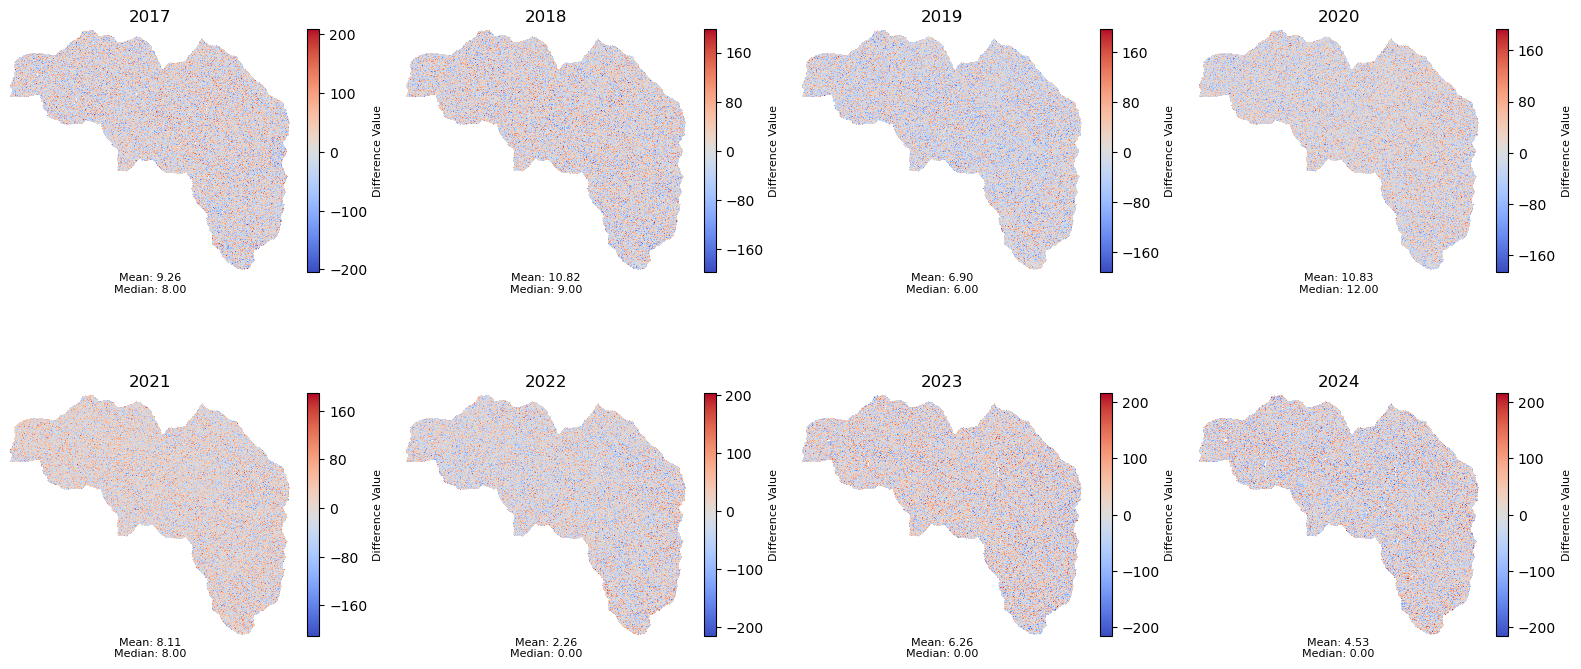

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import os
from matplotlib.ticker import MaxNLocator

def visualize_raster_differences_and_statistics(folder_path, stats_csv_path, output_figure_path):
    # Load statistics from CSV
    stats_df = pd.read_csv(stats_csv_path)
    
    # Get all raster files from the folder
    raster_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
    
    # Extract years from filenames and sort files by year
    rasters_by_year = sorted(raster_files, key=lambda x: int(x.split('_')[0]))
    
    # Set up figure (2 rows x 4 columns for 8 rasters)
    n_rasters = len(rasters_by_year)
    n_cols = 4
    n_rows = (n_rasters + n_cols - 1) // n_cols  # Ensure enough rows for all rasters
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = axes.flatten()  # Flatten in case we have extra subplots
    
    # Initialize variables for shared color scale
    all_differences = []

    # Iterate through rasters and plot them with statistics
    for idx, raster_file in enumerate(rasters_by_year):
        raster_path = os.path.join(folder_path, raster_file)
        year = int(raster_file.split('_')[0])  # Extract year from the filename
        
        with rasterio.open(raster_path) as src:
            # Read the raster data (first band)
            data = src.read(1)
            nodata = src.nodata
            if nodata is not None:
                data = np.where(data == nodata, np.nan, data)
            
            # Display raster difference (subtract first year or previous year)
            prev_raster_path = os.path.join(folder_path, rasters_by_year[idx - 1])
            with rasterio.open(prev_raster_path) as prev_src:
                prev_data = prev_src.read(1)
                if prev_src.nodata is not None:
                    prev_data = np.where(prev_data == prev_src.nodata, np.nan, prev_data)
                    
                difference = data - prev_data
                all_differences.append(difference)  # Store all differences for the color scale
                im = axes[idx].imshow(difference, cmap="coolwarm", interpolation="none")
                axes[idx].set_title(f"{year}")
            
            
            # Get statistics for the current year
            year_stats = stats_df[stats_df['Year'] == year].iloc[0]
            mean_value = year_stats['Mean']
            median_value = year_stats['Median']
            
            # Display statistics in the figure
            axes[idx].text(0.5, -0.1, f"Mean: {mean_value:.2f}\nMedian: {median_value:.2f}",
                           ha='center', va='bottom', transform=axes[idx].transAxes, fontsize=8, color='black')
            
            axes[idx].axis('off')  # Remove axes for cleaner presentation


            # Add individual colorbars with the same scale
            cbar = fig.colorbar(im, ax=axes[idx], shrink=0.6)
            cbar.set_label('Difference Value', fontsize=8)

            # Adjust colorbar ticks (optional, adjust number of ticks)
            cbar.locator = MaxNLocator(integer=True, nbins=5)
            cbar.update_ticks()
    
    # Remove empty subplots (if any)
    for i in range(n_rasters, len(axes)):
        fig.delaxes(axes[i])
    
    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(output_figure_path)
    plt.show()

# Visualize the differences and statistics
visualize_raster_differences_and_statistics("differenced_10m", "differenced_10m/stats", "difference_vvandvh_10m.png")


In [6]:
# 2017 5m
calculate_raster_difference("output_vh_5/runoff_onset_2017_vh_5.tif", "output_vv_5/runoff_onset_2017_vv_5.tif", "differenced_5m/2017_5.tif")

In [7]:
# 2018 5m
calculate_raster_difference("output_vh_5/runoff_onset_2018_vh_5.tif", "output_vv_5/runoff_onset_2018_vv_5.tif", "differenced_5m/2018_5.tif")

In [8]:
# 2019 5m
calculate_raster_difference("output_vh_5/runoff_onset_2019_vh_5.tif", "output_vv_5/runoff_onset_2019_vv_5.tif", "differenced_5m/2019_5.tif")

In [9]:
# 2020 5m
calculate_raster_difference("output_vh_5/runoff_onset_2020_vh_5.tif", "output_vv_5/runoff_onset_2020_vv_5.tif", "differenced_5m/2020_5.tif")

In [10]:
# 2021 5m
calculate_raster_difference("output_vh_5/runoff_onset_2021_vh_5.tif", "output_vv_5/runoff_onset_2021_vv_5.tif", "differenced_5m/2021_5.tif")

In [11]:
# 2022 5m
calculate_raster_difference("output_vh_5/runoff_onset_2022_vh_5.tif", "output_vv_5/runoff_onset_2022_vv_5.tif", "differenced_5m/2022_5.tif")

In [28]:
# 2023 5m
calculate_raster_difference("output_vh_5/runoff_onset_2023_vh_5.tif", "output_vv_5/runoff_onset_2023_vv_5.tif", "differenced_5m/2023_5.tif")

In [13]:
# 2024 5m
calculate_raster_difference("output_vh_5/runoff_onset_2024_vh_5.tif", "output_vv_5/runoff_onset_2024_vv_5.tif", "differenced_5m/2024_5.tif")

In [29]:
# Calculate and save statistics
calculate_and_save_raster_statistics("differenced_5m", "differenced_5m/stats")


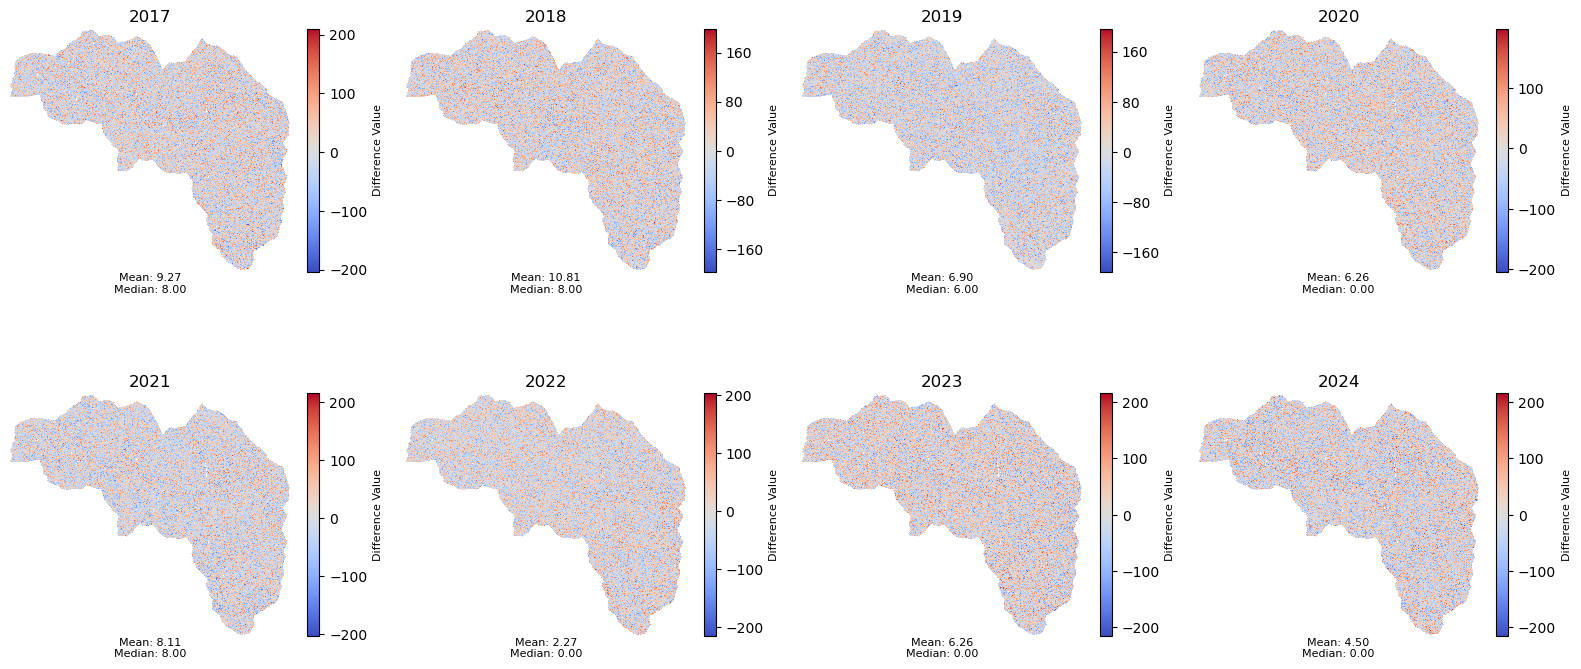

In [30]:
# Visualize the differences and statistics
visualize_raster_differences_and_statistics("differenced_5m", "differenced_5m/stats", "difference_vvandvh_5m.png")

# VH consistently calculates an earlier day of onset melt for both spatial resolutions